In [1]:
import emcee
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colorbar import Colorbar
import astropy.io.fits as pyfits
import scipy.optimize as opt
import corner
import os
import utils as myUtils
import scipy.integrate as integrate
import matplotlib.gridspec as gridspec
from matplotlib.patches import Ellipse
from scipy import stats
import arviz
from astropy.modeling.functional_models import Sersic2D
from multiprocessing import Pool
from matplotlib.colors import LogNorm, SymLogNorm
import pandas as pd
import numpy.ma as ma
from matplotlib.patches import Circle
import time
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from models import Delta2D

In [2]:
data = pd.DataFrame(columns=['Source','SN','Relative RA [arcsec]', 'Relative RA low', 'Relative RA up',
                  'Relative Dec [arcsec]','Relative Dec low','Relative Dec up','FWHM x [arcsec]',
                  'FWHM x low','FWHM x up','FWHM y [arcsec]','FWHM y low',
                  'FWHM y up','Angle G [deg]','Angle G low','Angle G up',
                  'Amplitude G [mJy]','Amplitude G low','Amplitude G up',
                  'Amplitude S [mJy]','Amplitude S low','Amplitude S up',
                  'Angle S [deg]','Angle S low','Angle S up',
                  'Effective radius [arcsec]','Effective radius low','Effective radius up',
                  'Ellipticity','Ellipticity low','Ellipticity up',                  
                  'Beam min [arcsec]', 'Beam maj [arcsec]', 'BIC', 'Flux [mJy]', 'Flux err'])

In [217]:
path = r'G:\Mi unidad\Universidad\Master_Astro\TFM\ALMA_images\Original\\'
sources = os.listdir(path)
# file = 17

fits_file  = pyfits.open(path+'cont_clean_AL-84.1_allspw_briggs.image.fits')
name = 'AL115.1'
image_data = fits_file[0].data[0][0]
image_data.shape

(900, 900)

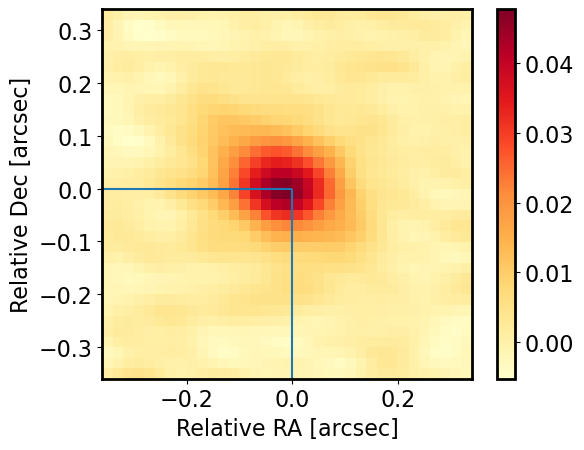

In [218]:
flux = myUtils.zoom(image_data,35)
sn = myUtils.s_n(flux)


x_center = flux.shape[0]/2 
y_center = flux.shape[1]/2
ra_center=fits_file[0].header['CRVAL1']
dec_center=fits_file[0].header['CRVAL2']
dx=fits_file[0].header['CDELT1']
dy=fits_file[0].header['CDELT2']
bmaj=fits_file[0].header['BMAJ']  #convert from degrees to arcsec
bmin=fits_file[0].header['BMIN']
bpa=fits_file[0].header['BPA']

flux = flux * 10**3 * ( (4 * np.log(2) / (np.pi * bmaj * bmin/(dx**2))))
sn = myUtils.s_n(flux)

x_extent = (np.array([0., flux.shape[1]]) - (flux.shape[1] - x_center + 0.5)) * dx * 3600 * (-1)  # half pixel to center the map
y_extent = (np.array([0., flux.shape[0]]) - (flux.shape[0] - y_center + 0.5)) * dy * 3600
extent = [x_extent[0], x_extent[1], y_extent[0], y_extent[1]]

x_grid = np.linspace(x_extent[0], x_extent[1], flux.shape[1])
y_grid = np.linspace(y_extent[0], y_extent[1], flux.shape[0])
x_grid, y_grid = np.meshgrid(x_grid, y_grid)

fig, ax = plt.subplots()
plt1 = ax.imshow(flux, cmap='YlOrRd', origin='lower', extent=extent, vmin=flux.min(), vmax=flux.max())
fig.colorbar(ax=ax, mappable=plt1, orientation='vertical')
ax.set_xlabel('Relative RA [arcsec]')
ax.set_ylabel('Relative Dec [arcsec]')
ax.hlines(0,-.5,0)
ax.vlines(0,-.5,0)
plt.xlim(x_extent[0],x_extent[1])
plt.ylim(y_extent[0],y_extent[1])
plt.show()

In [5]:
# from models import Delta2D
# model = Delta2D(amplitude=1,x_0=0,y_0=0)
# model(x_grid,y_grid)

In [6]:
# idx_center = np.where(flux==np.max(flux))

# rms = myUtils.std_image((flux))
# r_eff_ = np.linspace(0,0.8,500)
# flux_list = []
# for i in r_eff_:#r_eff
#     mascara = ma.masked_less_equal(np.sqrt((x_grid-x_grid[idx_center[0][0]][idx_center[0][0]])**2 + (y_grid-y_grid[idx_center[0][0]][idx_center[0][0]])**2),i) 
#     flux_ = flux[mascara.mask]
#     flux_list.append(np.sum(flux_))
                                   
# r_eff = np.interp(np.sum(flux)/2, flux_list, r_eff_)                                  

In [7]:
# plt.plot(r_eff_,flux_list)
# # plt.plot(np.linspace(0,0.8,100),np.interp(np.linspace(0,0.8,100), r_eff_,flux_list))
# plt.xlabel('Reff [arcsec]')
# plt.ylabel('Flux [mJy]')
# plt.title('Growth curve')
# print('Reff: ', np.interp(np.max(flux_list)/2, flux_list, r_eff_), ' Total flux = ',np.sum(flux) )
# plt.show()

In [8]:
# fig, ax = plt.subplots()
# plt1 = ax.imshow(flux, cmap='YlOrRd', origin='lower', extent=extent, vmin=flux.min(), vmax=flux.max())
# fig.colorbar(ax=ax, mappable=plt1, orientation='vertical')
# ax.set_xlabel('Relative RA [arcsec]')
# ax.set_ylabel('Relative Dec [arcsec]')
# # ax.hlines(0,-.5,0)
# # ax.vlines(0,-.5,0)
# plt.xlim(x_extent[0],x_extent[1])
# plt.ylim(y_extent[0],y_extent[1])
# cir1 = plt.Circle((x_grid[idx_center[0][0]][idx_center[0][0]], x_grid[idx_center[0][0]][idx_center[0][0]]), 
#            radius=r_eff,fill=False)
# cir2 = plt.Circle((x_grid[idx_center[0][0]][idx_center[0][0]], x_grid[idx_center[0][0]][idx_center[0][0]]), 
#            radius=0.1517930170956946 * 0.5 *  2 * np.sqrt(2 * np.log(2)),fill=False)
# fit_ellipse = Ellipse((x_0_emcee, y_0_emcee), width=0.5 * FWHM_x_emcee * 2, height=0.5 * FWHM_y_emcee * 2,
#                                       angle=pa_deg_emcee, facecolor='none', edgecolor='blue', alpha=1.0, lw=1,
#                                       zorder=200)
# ax.add_patch(cir1)
# ax.add_patch(cir2)
# ax.add_patch(fit_ellipse)

# plt.show()

In [219]:
np.where(flux==np.max(flux))
cuadrante_1 = flux[18:34,0:16]
cuadrante_2 = flux[0:16,0:16]

if sum(cuadrante_2.ravel()>=0.4) > sum(cuadrante_1.ravel()>=0.4):
    row, col = np.where(cuadrante_2 == np.max(cuadrante_2))
    r = np.sqrt(row**2 +col**2)
    angle = 180 - np.arcsin(col/r) * 180/np.pi
    
else:
    row, col = np.where(cuadrante_1 == np.max(cuadrante_1))
    r = np.sqrt(row**2 +col**2)
    angle = np.arcsin(col/r) * 180/np.pi

In [220]:
I = flux
x = x_grid
y = y_grid
M0 = I.sum()
x0 = (x*I).sum()/M0
y0 = (y*I).sum()/M0
Mxx = (x*x*I).sum()/M0 - x0*x0
Myy = (y*y*I).sum()/M0 - y0*y0
Mxy = (x*y*I).sum()/M0 - x0*y0
D = 2*(Mxx*Myy-Mxy*Mxy)
a = Myy/D
c = Mxx/D
b = -Mxy/D


# Find the area of one pixel expressed in grids to find amplitude A
   
theta = np.degrees(0.5*np.arctan(2*c/(b-a))) 
if theta<0:  # Not HW1 but the largest axis corresponds to theta.
    theta+=180


In [221]:
theta

151.9858183492601

In [222]:
bmin_s = np.abs(bmin*3600)/(2 * np.sqrt(2 * np.log(2))) # unidades de sigma
bmaj_s = np.abs(bmaj*3600)/(2 * np.sqrt(2 * np.log(2)))
# bmin_s = np.abs(bmin*3600) # unidades de r eff
# bmaj_s = np.abs(bmaj*3600)

In [240]:
profile = 'C'
max_flux = np.max(flux)
popt, pcov = myUtils.get_parameter_curve_fit(flux,x_grid,y_grid, max_flux = np.max(flux), profile=profile, beam= [bmin_s,bmaj_s],
                                             dy = dy,bpa=bpa)

if profile=='A':
    amplitude_sersic, r_eff, x_0, y_0, ellip, angle_sersic = popt #sersic
    pos = [amplitude_sersic, r_eff, x_0, y_0, ellip, angle_sersic]
    labels = ['amplitude_sersic', 'r_eff', 'x_0', 'y_0', 'ellip', 'angle_sersic']
    
elif profile=='B':
    x_0, y_0, sigma_y, sigmax_minus_y, amplitude, theta = popt #gaussian
    sigma_x = sigma_y + np.abs(sigmax_minus_y)
    pos = [amplitude, x_0, y_0, sigma_x, sigma_y, 162]
    labels = ['amplitude', 'x_0', 'y_0', 'sigma_x', 'sigma_y', 'theta'] 

elif profile=='C':
    x_0, y_0, sigma_y, sigmax_minus_y, amplitude, theta, amplitude_sersic, r_eff, ellip, angle_sersic = popt
    sigma_x = sigma_y + np.abs(sigmax_minus_y)
    pos = [amplitude, x_0, y_0, bmaj_s, bmin_s, theta, amplitude_sersic, r_eff, ellip,angle_sersic]
    labels =['amplitude', 'x_0', 'y_0', 'sigma_x', 'sigma_y', 'theta', 'amplitude_sersic', 'r_eff','ellip','angle_sersic']

elif profile=='D':
    x_0, y_0, amplitude,amplitude_sersic, r_eff, ellip, angle_sersic, _, _, _, _ = popt
    pos = [x_0, y_0, amplitude,amplitude_sersic, r_eff, ellip, angle_sersic]
    labels =['x_0', 'y_0', 'amplitude', 'amplitude_sersic', 'r_eff','ellip','angle_sersic']



In [241]:
for i, j in enumerate(labels):
    print(j+':', pos[i])

amplitude: 0.025730579139996428
x_0: -0.01855543154934984
y_0: 0.005552602974938369
sigma_x: 0.054537842672777184
sigma_y: 0.031206438032962382
theta: 38.96337487701003
amplitude_sersic: 0.005676094948914911
r_eff: 0.14107431844936963
ellip: 0.3704020908595445
angle_sersic: 156.39019469676148


In [242]:
ndim, nwalkers = len(pos),600
pos = [np.abs(np.random.normal(pos, 0.01)) for i in range(nwalkers)] # initialing araund a normal with mu equal to curvfit values

#pos = [np.random.uniform(0.8,1.2,size=ndim) * np.array(pos)  for i in range(nwalkers)]
#pos = [np.random.uniform(-0.5,0.5,size=ndim) + np.array(pos)  for i in range(nwalkers)]


In [ ]:
dtype = [("log_likelihood_", object)]
with Pool() as pool:
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, myUtils.log_probability,
                                args=[x_grid.ravel(), y_grid.ravel(), flux.ravel(),
                                      myUtils.std_image(flux), [],
                                      bmin_s,bmaj_s,bpa,max_flux,dx,profile],
                                pool=pool)#, blobs_dtype=dtype)
#    print("Running burn-in...")
#     state = sampler.run_mcmc(pos, 100)
#     sampler.reset()

    print("Running production...")
    sampler.run_mcmc(pos, 5000, progress=True);

Running production...


  0%|          | 0/5000 [00:00<?, ?it/s]C:\Users\agzal\.conda\envs\TEA\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
 23%|██▎       | 1135/5000 [03:33<10:40,  6.04it/s]

In [227]:
print(
"Mean acceptance fraction: {0:.3f}".format(
np.mean(sampler.acceptance_fraction)
)
)

# print(
#     "Mean autocorrelation time: {0:.3f} steps".format(
#         np.mean(sampler.get_autocorr_time())
#     )
# )

Mean acceptance fraction: 0.416


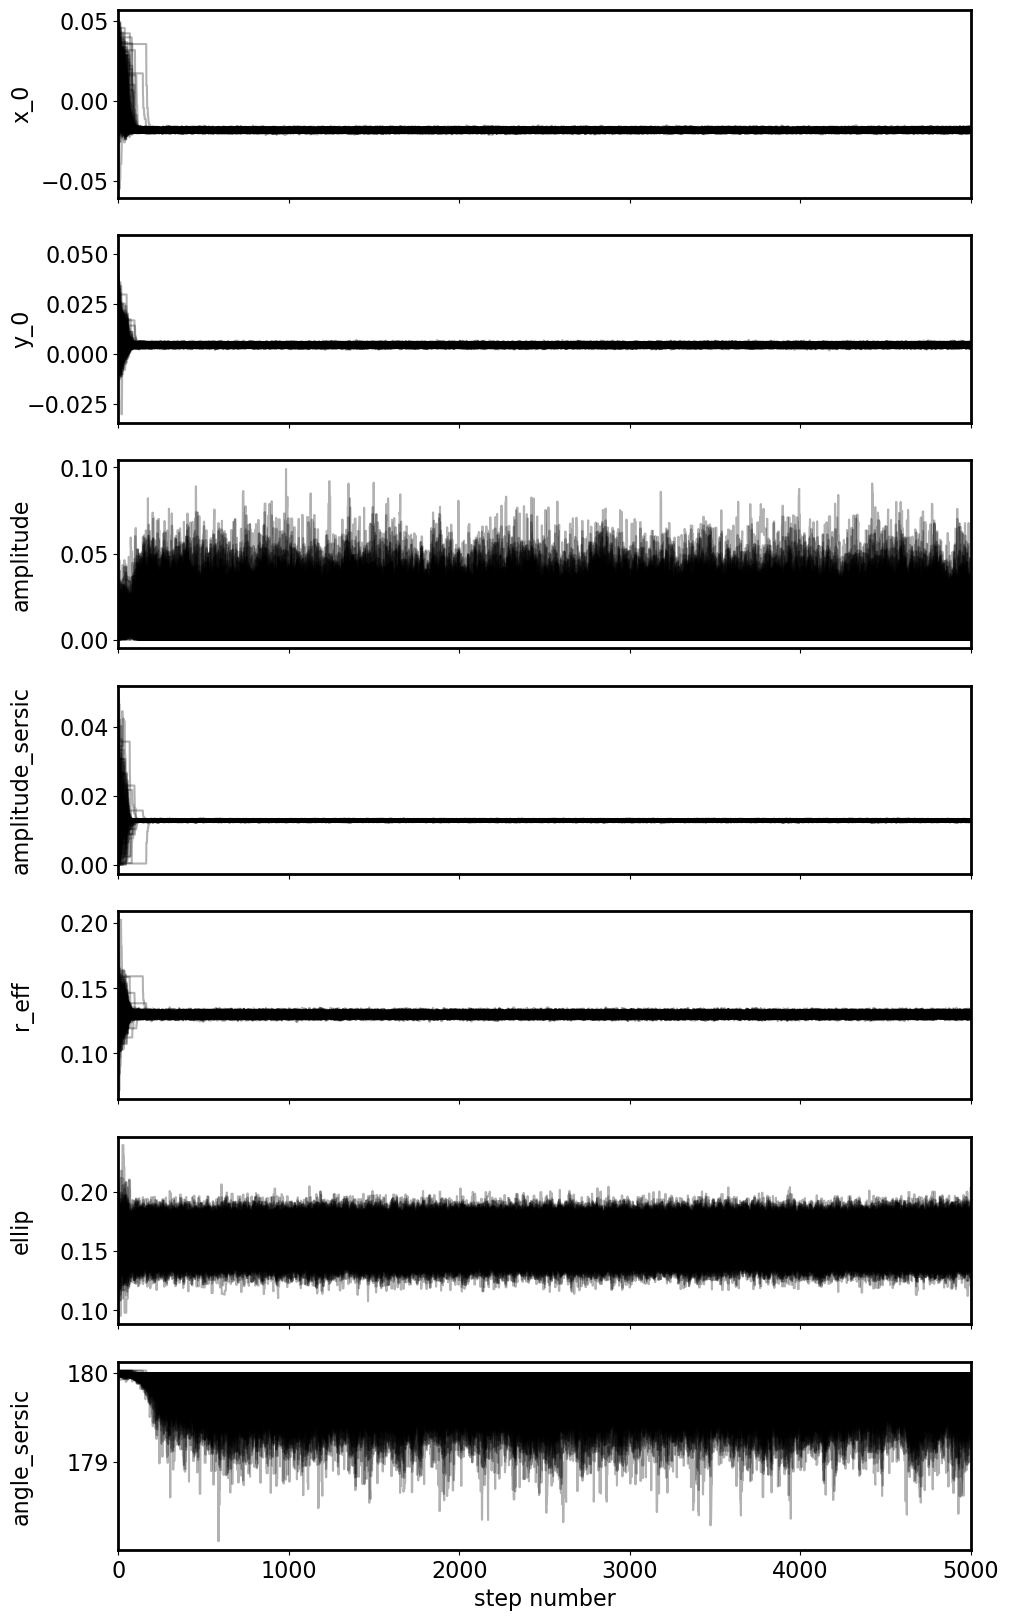

In [228]:
fig, axes = plt.subplots(len(labels), figsize=(11, 20), sharex=True)
samples = sampler.get_chain()

for i in range(len(labels)):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
# plt.savefig(r'G:\Mi unidad\Universidad\Master_Astro\TFM\ALMA_images\Fitted\Gaussian+Sersic\Chains\chains_'+name+'.jpg')
del(samples)

(180000, 7)


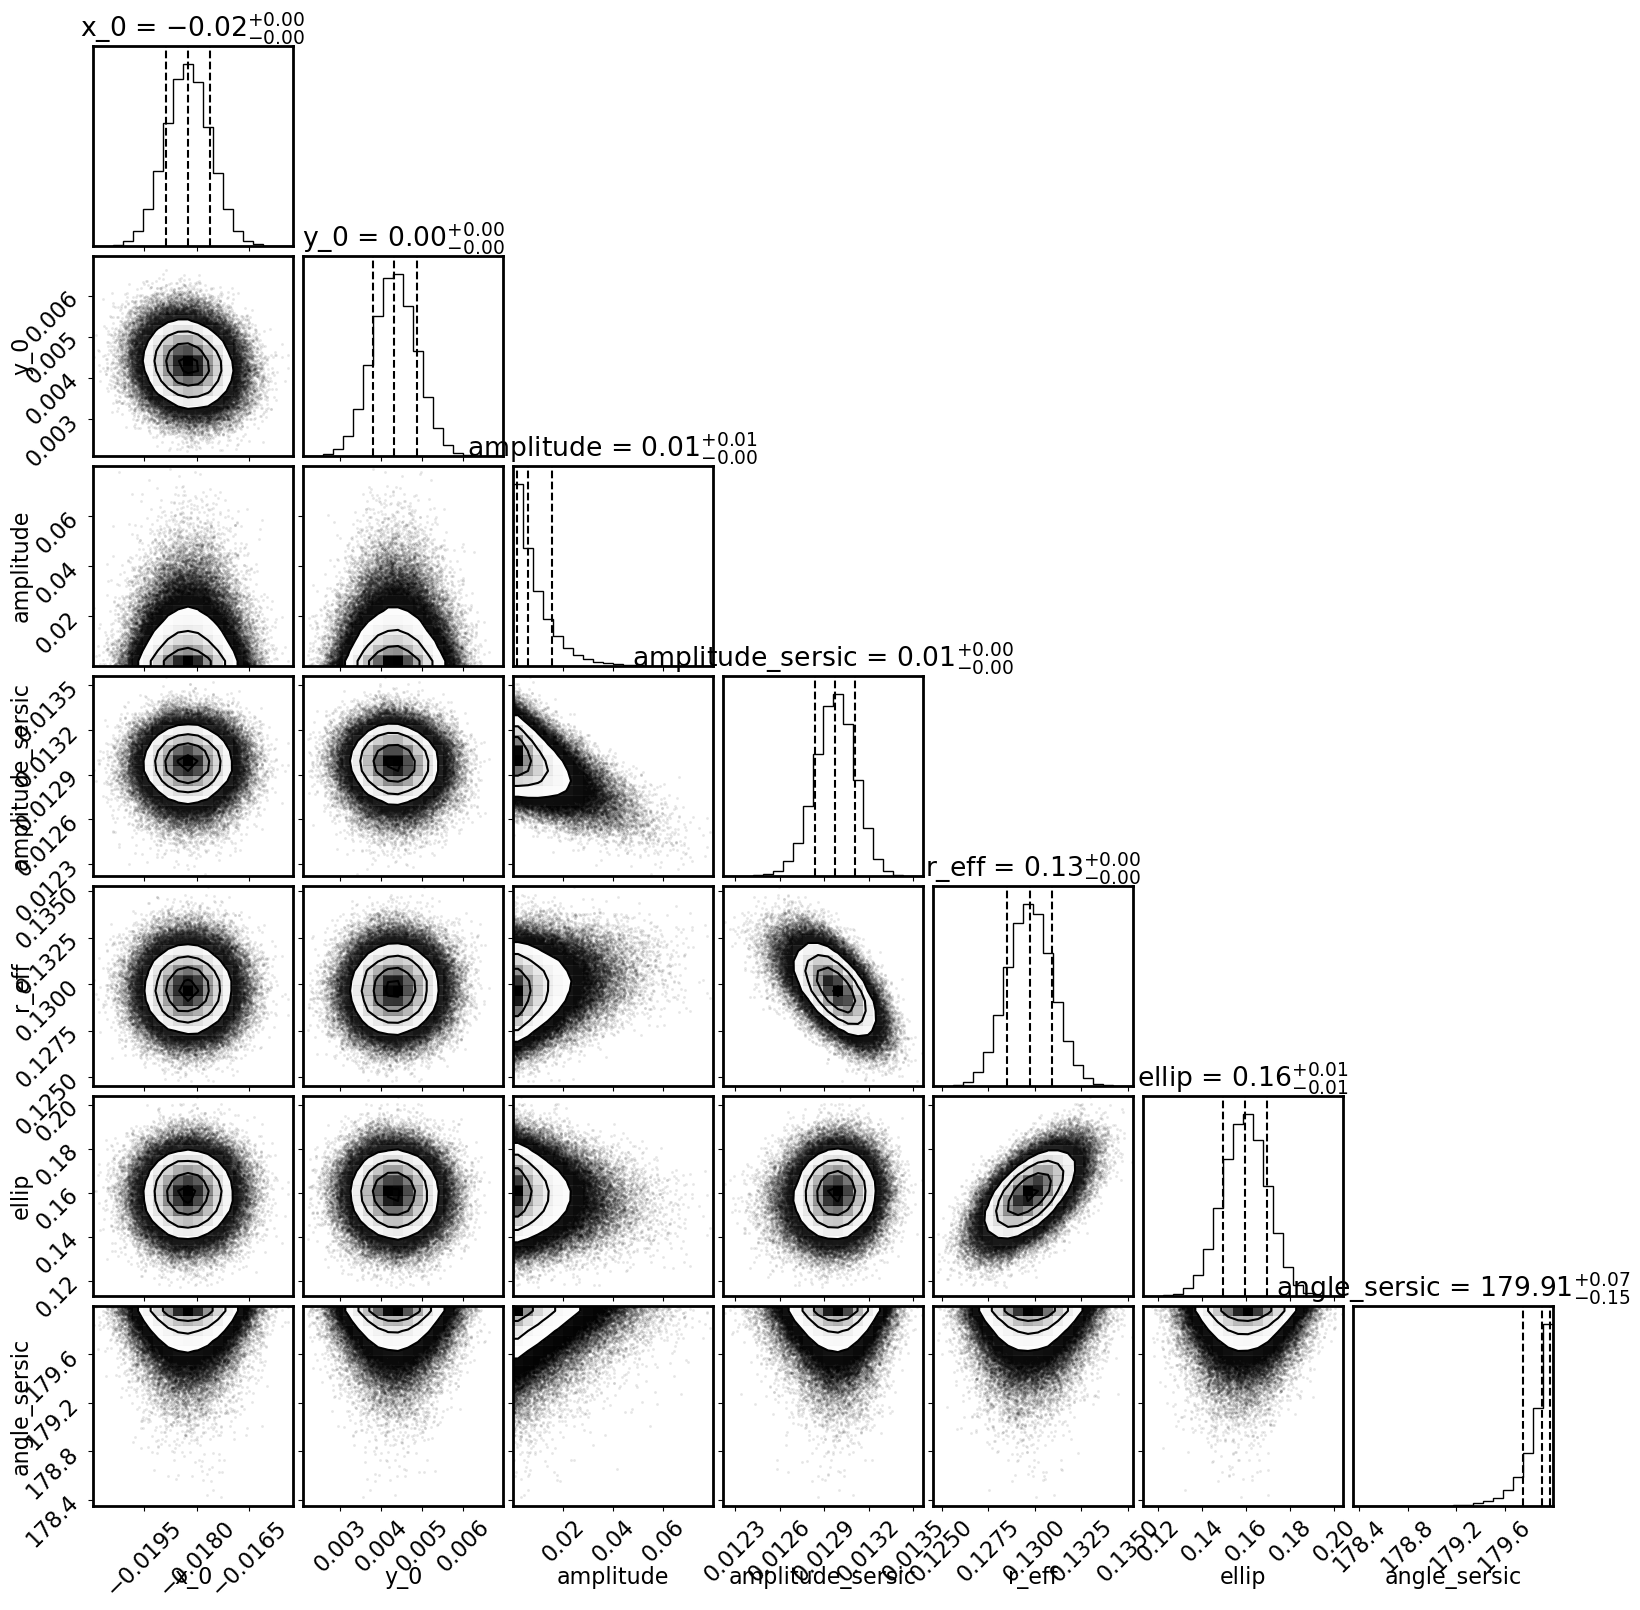

In [229]:
flat_samples = sampler.get_chain(discard=2000, thin=10, flat=True)
print(flat_samples.shape)
fig = corner.corner(flat_samples, labels=labels, quantiles=[0.16, 0.5, 0.84],
                    show_titles=True)
#plt.savefig(r'G:\Mi unidad\Universidad\Master_Astro\TFM\ALMA_images\Fitted\Gaussian+Sersic\Corner_plot\coner_Plot_'+name+'.png')

In [230]:
flat= sampler.get_chain(discard=2000, thin=1)
means = np.mean(flat,axis=1)
stds = np.std(flat,axis=1)

valid_chains = {}
for i in range(len(labels)):
    samples = sampler.get_chain(discard=2000, thin=1)
    valid_chain_i = []
    for j in range(600):
        chain = samples[:,j,i]
        std = stds[j,i]
        cond1 = np.all(chain < means[j,i] + 10*std)
        cond2 = np.all(chain > means[j,i] - 10*std)
        if cond1 and cond2:
            valid_chain_i.append(chain)
        else:
            valid_chain_i.append(np.ones(shape=chain.shape[0])*np.nan)


    valid_chain_i = np.array([item for sublist in valid_chain_i for item in sublist])
    valid_chains[labels[i]] =  valid_chain_i


In [231]:
a = pd.DataFrame(valid_chains).dropna(axis=0)

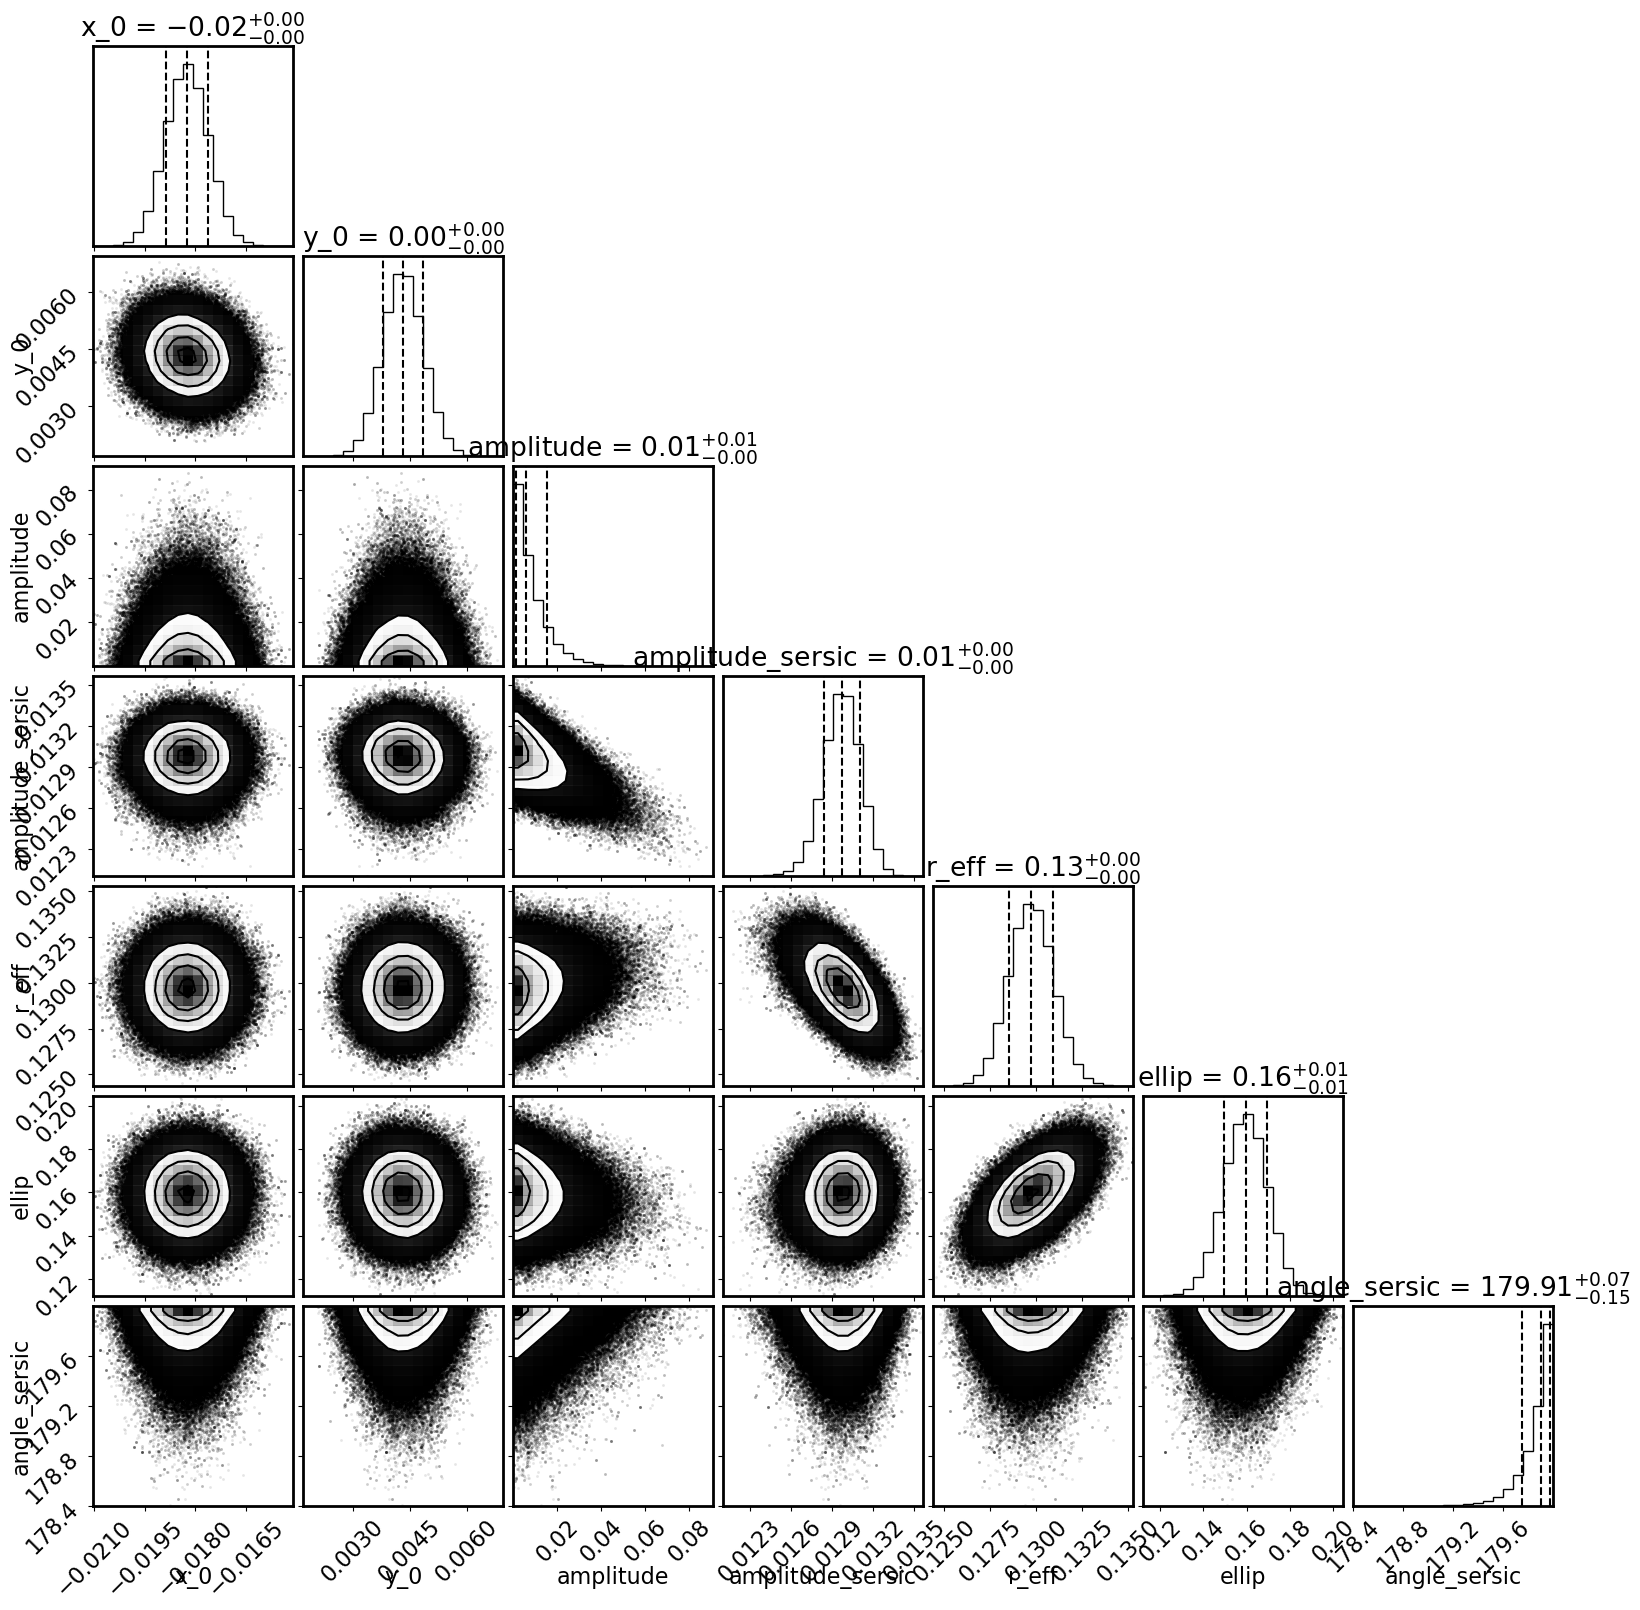

In [232]:
fig = corner.corner(a, labels=list(valid_chains.keys()), quantiles=[0.16, 0.5, 0.84], show_titles=True)


In [233]:
parameters_fit_50 = []
upper_limits = []
low_limits = []
#hdp = [] # highest posterior density (HPD) of array for given alpha 0.05
for j in range(ndim):
    mcmc = np.percentile(flat_samples[5000:, j], [16, 50, 84])
    #hpd_, _, _, _ = myUtils.hpd_grid(flat_samples[100:, j])
    q = np.diff(mcmc)
    parameters_fit_50.append(mcmc[1])
    low_limits.append(q[0])
    upper_limits.append(q[1])
    

    
   # hdp.append(hpd_)
#hdp = np.asarray(hdp)
# del(flat_samples)

In [234]:
np.max(flux)

0.04778605

In [235]:
for i, j in enumerate(labels):
    print(j+':', parameters_fit_50[i])

x_0: -0.01825325007231403
y_0: 0.004321928281730242
amplitude: 0.006039307121008445
amplitude_sersic: 0.012974129112992337
r_eff: 0.1297254641846573
ellip: 0.15950408984836126
angle_sersic: 179.90706670895938


In [236]:
bmaj_s

0.054537842672777184

In [237]:
# convert from pixel to relative RA and DEC
# centering on the image center or on the target -> x_center, y_center
dx=fits_file[0].header['CDELT1']
dy=fits_file[0].header['CDELT2']
bmaj=fits_file[0].header['BMAJ'] #convert from degrees to arcsec
bmin=fits_file[0].header['BMIN']

flux2 = myUtils.zoom(image_data,51) * 10**3 * ( (4 * np.log(2) / (np.pi * bmaj * bmin/(dx**2))))
x_center2 = flux2.shape[0]/2 
y_center2 = flux2.shape[1]/2
x_extent2 = (np.array([0., flux2.shape[1]]) - (flux2.shape[1] - x_center2 + 0.5)) * dx * 3600 * (-1)  # half pixel to center the map
y_extent2 = (np.array([0., flux2.shape[0]]) - (flux2.shape[0] - y_center2 + 0.5)) * dy * 3600
extent2 = [x_extent2[0], x_extent2[1], y_extent2[0], y_extent2[1]]

x_grid2 = np.linspace(x_extent2[0], x_extent2[1], flux2.shape[1])
y_grid2 = np.linspace(y_extent2[0], y_extent2[1], flux2.shape[0])
x_grid2, y_grid2 = np.meshgrid(x_grid2, y_grid2)

# shift = ((flux2.shape[1]-flux.shape[1])/2)*dx*3600

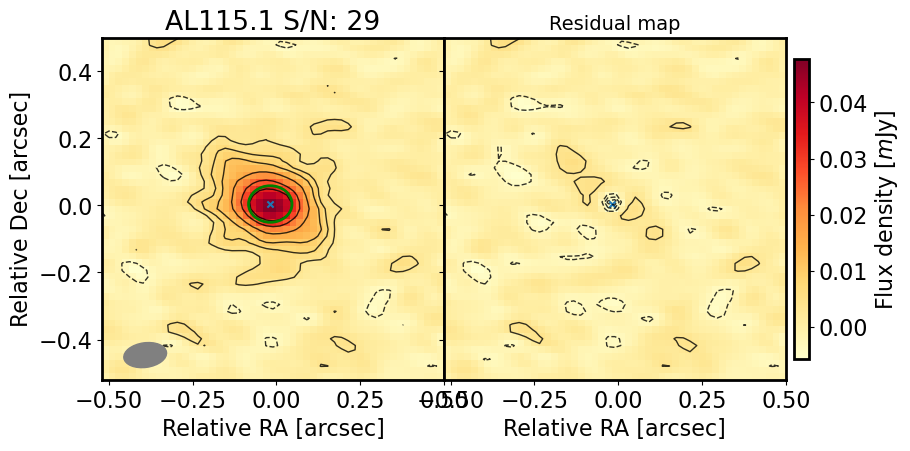

In [238]:
## todos los plots en unidades de radio efectivo

plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'xtick.labelsize': 16})
plt.rcParams.update({'ytick.labelsize': 16})
plt.rcParams.update({'axes.linewidth': 2})
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=(10.5, 5))

plt1 = ax[0].imshow(flux2, cmap='YlOrRd', origin='lower', extent=extent2, vmin=flux2.min(), vmax=flux2.max())

rms = myUtils.std_image(flux2)

levels = [-2 * rms, 2 * rms, 4 * rms, 6 * rms, 10 * rms, 15 * rms, 20 * rms]
plt2 = ax[0].contour(flux2, levels, colors='k', alpha=0.8, linewidths=1.0, extent=extent2)
ax[0].set_xlabel('Relative RA [arcsec]')
ax[0].set_ylabel('Relative Dec [arcsec]')

# plot the best fit ellipse emcee
if profile == 'A':
    amplitude_sersic_emcee, r_eff_emcee, x_0_emcee, y_0_emcee, ellip_emcee, angle_sersic_emcee= parameters_fit_50
    amplitude_sersic_emcee_up, r_eff_emcee_up, x_0_emcee_up, y_0_emcee_up, ellip_emcee_up, angle_sersic_emcee_up = upper_limits
    amplitude_sersic_emcee_low, r_eff_emcee_low, x_0_emcee_low, y_0_emcee_low, ellip_emcee_low, angle_sersic_emcee_low = low_limits
    ax[0].scatter(x_0_emcee, y_0_emcee, marker="x", s=20)

    a, b = r_eff_emcee, (1 - ellip_emcee) * r_eff_emcee
    pa_deg_emcee = 180 - angle_sersic


    fit_ellipse_emcee_ser = Ellipse((x_0_emcee, y_0_emcee), width=a, height=b,
                                    angle=pa_deg_emcee, facecolor='none', edgecolor='green', alpha=1.0, lw=2,
                                    zorder=200)

    ax[0].add_artist(fit_ellipse_emcee_ser)
    mod = Sersic2D(amplitude=amplitude_sersic_emcee, r_eff=r_eff_emcee, n=1, x_0=x_0_emcee, y_0=y_0_emcee, ellip=ellip_emcee,
                   theta=np.radians(180 - angle_sersic))
    fobs2 = mod(x_grid2, y_grid2)

if profile == 'B':
    amplitude_emcee, x_0_emcee, y_0_emcee, sigma_x_emcee, sigma_y_emcee, angle_emcee = parameters_fit_50
    amplitude_emcee_up, x_0_emcee_up, y_0_emcee_up, sigma_x_emcee_up, sigma_y_emcee_up, angle_emcee_up = upper_limits
    amplitude_emcee_low, x_0_emcee_low, y_0_emcee_low, sigma_x_emcee_low, sigma_y_emcee_low, angle_emcee_low = low_limits
    ax[0].scatter(x_0_emcee, y_0_emcee, marker="x", s=20)

    FWHM_x_emcee = 2 * np.sqrt(2 * np.log(2)) * sigma_x_emcee
    FWHM_y_emcee = 2 * np.sqrt(2 * np.log(2)) * sigma_y_emcee
    pa_deg_emcee = 180 - angle_emcee
    fit_ellipse_emcee_gauss = Ellipse((x_0_emcee, y_0_emcee), width=0.5 * FWHM_x_emcee*2, height=0.5 * FWHM_y_emcee * 2,
                                      angle=pa_deg_emcee, facecolor='none', edgecolor='blue', alpha=1.0, lw=1,
                                      zorder=200)
    ax[0].add_artist(fit_ellipse_emcee_gauss)
    Gauss = myUtils.model_twoD_Gaussian(
        [amplitude_emcee, x_0_emcee, y_0_emcee, sigma_x_emcee, sigma_y_emcee, angle_emcee],
        x_grid2, y_grid2).reshape(50, 50)
    fobs2 = Gauss

if profile == 'C':
    amplitude_emcee, x_0_emcee, y_0_emcee, sigma_x_emcee, sigma_y_emcee, angle_emcee, amplitude_sersic_emcee, r_eff_emcee, ellip_emcee, angle_sersic_emcee = parameters_fit_50
    amplitude_emcee_up, x_0_emcee_up, y_0_emcee_up, sigma_x_emcee_up, sigma_y_emcee_up, angle_emcee_up, amplitude_sersic_emcee_up, r_eff_emcee_up, ellip_emcee_up, angle_sersic_emcee_up = upper_limits
    amplitude_emcee_low, x_0_emcee_low, y_0_emcee_low, sigma_x_emcee_low, sigma_y_emcee_low, angle_emcee_low, amplitude_sersic_emcee_low, r_eff_emcee_low, ellip_emcee_low, angle_sersic_emcee_low = low_limits
    ax[0].scatter(x_0_emcee, y_0_emcee, marker="x", s=20)

    FWHM_x_emcee = 2 * np.sqrt(2 * np.log(2)) * sigma_x_emcee
    FWHM_y_emcee = 2 * np.sqrt(2 * np.log(2)) * sigma_y_emcee
    pa_deg_emcee = 180 - angle_emcee
    fit_ellipse_emcee_gauss = Ellipse((x_0_emcee, y_0_emcee), width=0.5 * FWHM_x_emcee*2, height=0.5 * FWHM_y_emcee*2,
                                      angle=pa_deg_emcee, facecolor='none', edgecolor='blue', alpha=1.0, lw=1,
                                      zorder=200)
    ax[0].add_artist(fit_ellipse_emcee_gauss)
    Gauss = myUtils.model_twoD_Gaussian([amplitude_emcee, x_0_emcee, y_0_emcee, sigma_x_emcee, sigma_y_emcee, angle_emcee],x_grid2, y_grid2).reshape(51, 51)
    beam_gauss_kernel = Gaussian2DKernel(bmaj_s /(dy*3600),bmin_s /(dy*3600),theta=np.radians(bpa-90),x_size=51)
    astropy_conv = convolve(Gauss, beam_gauss_kernel)

    a, b = r_eff_emcee, (1 - ellip_emcee) * r_eff_emcee
    pa_deg_emcee = 180 - angle_sersic_emcee

    fit_ellipse_emcee_ser = Ellipse((x_0_emcee, y_0_emcee), width=a*2, height=b*2,
                                    angle=pa_deg_emcee, facecolor='none', edgecolor='green', alpha=1.0, lw=2,
                                    zorder=200)

    ax[0].add_artist(fit_ellipse_emcee_ser)
    mod = Sersic2D(amplitude=amplitude_sersic_emcee, r_eff=r_eff_emcee, n=1, x_0=x_0_emcee, y_0=y_0_emcee, ellip=ellip_emcee,
                   theta=np.radians(180 - angle_sersic_emcee))
    Sersic = mod(x_grid2, y_grid2)

    fobs2 = Sersic + astropy_conv

    ax[0].legend(handles=[fit_ellipse_emcee_gauss, fit_ellipse_emcee_ser],
                 labels=['Gaussian ellipse', 'Sersic ellipse'], fontsize=10)

if profile == 'D':
    x_0_emcee, y_0_emcee, amplitude_emcee,amplitude_sersic_emcee, r_eff_emcee, ellip_emcee, angle_sersic_emcee = parameters_fit_50
    x_0_up, y_0_up, amplitude_up,amplitude_sersic_up, r_eff_up, ellip_up, angle_sersic_up = upper_limits
    x_0_low, y_0_low, amplitude_low,amplitude_sersic_low, r_eff_low, ellip_low, angle_sersic_low = low_limits
    ax[0].scatter(x_0_emcee, y_0_emcee, marker="x", s=20)


    a, b = r_eff_emcee, (1 - ellip_emcee) * r_eff_emcee
    pa_deg_emcee = 180 - angle_sersic


    fit_ellipse_emcee_ser = Ellipse((x_0_emcee, y_0_emcee), width=a, height=b,
                                    angle=pa_deg_emcee, facecolor='none', edgecolor='green', alpha=1.0, lw=2,
                                    zorder=200)

    ax[0].add_artist(fit_ellipse_emcee_ser)
    mod = Sersic2D(amplitude=amplitude_sersic_emcee, r_eff=r_eff_emcee, n=1, x_0=x_0_emcee, y_0=y_0_emcee, ellip=ellip_emcee,
                   theta=np.radians(180 - angle_sersic))
    mod_2 = Delta2D(amplitude=amplitude, x_0=x_0_emcee, y_0=y_0_emcee)
    mod_2 = mod_2(x_grid2, y_grid2)
    beam_gauss_kernel = Gaussian2DKernel(bmaj_s /(dy*3600),bmin_s /(dy*3600),theta=np.radians(bpa-90),x_size=51)
    astropy_conv = convolve(mod_2, beam_gauss_kernel)

    fobs2 = mod(x_grid2, y_grid2) + astropy_conv




ax[0].set_title(str(name)+' S/N: '+str(round(sn)))
# add beam of the observation
pa = bpa + 90
bmaj = fits_file[0].header['BMAJ'] * 3600  # convert from degrees to arcsec en unidades de fwhm
bmin = fits_file[0].header['BMIN'] * 3600
beam = Ellipse((x_extent2[0] + bmaj, y_extent2[0] + bmin), width=bmaj * 0.5*2, height=bmin * 0.5*2, angle=pa,
               facecolor='grey',
               edgecolor='grey', alpha=1.0, zorder=100)
ax[0].add_artist(beam)

plt3 = ax[1].imshow(flux2 - fobs2, cmap='YlOrRd', origin='lower', extent=extent2, vmin=flux2.min(), vmax=flux2.max())
ax[1].tick_params(axis='y', which='both', bottom=False, top=False, labelbottom=False)
rms2 = myUtils.std_image((flux2 - fobs2))
levels = [-8 * rms2, -6 * rms2, -4 * rms2, -2 * rms2, 2 * rms2, 4 * rms2, 6 * rms2, 8 * rms2]

plt4 = ax[1].contour((flux2 - fobs2), levels, colors='k', alpha=0.8, linewidths=1.0, extent=extent2)
ax[1].set_xlabel('Relative RA [arcsec]')
ax[1].set_title('Residual map', fontsize=14)
ax[1].scatter(x_0_emcee, y_0_emcee, marker="x",s=20)
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0, hspace=0.35)
cbar = fig.colorbar(plt1, ax=ax.ravel().tolist(), shrink=0.75, pad=0.01)
cbar.set_label(r'Flux density [$m$Jy]')

#plt.savefig(r'G:\Mi unidad\Universidad\Master_Astro\TFM\ALMA_images\Fitted\Gaussian+Sersic\Maps\map_fit_' + str(name) +'_'+profile+ '.jpg', dpi=250)

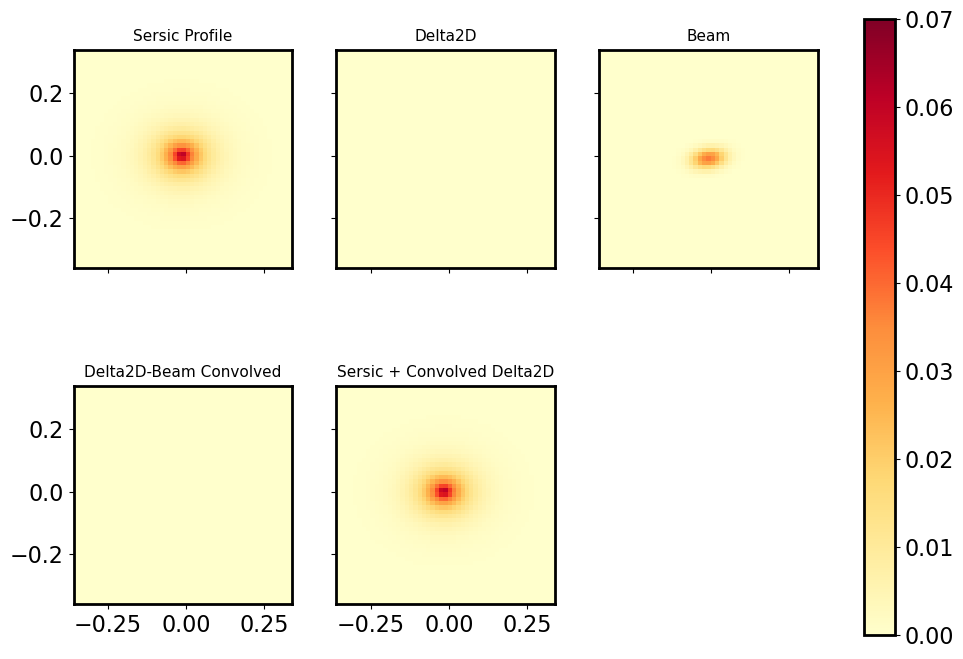

In [239]:
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

mod = Sersic2D(amplitude=amplitude_sersic_emcee, r_eff=r_eff_emcee, n=1, x_0=x_0_emcee, y_0=y_0_emcee, ellip=ellip_emcee,
                   theta=np.radians(180 - angle_sersic))
mod = mod(x_grid2, y_grid2)
mod_2 = Delta2D(amplitude=amplitude, x_0=x_0_emcee, y_0=y_0_emcee)
mod_2 = mod_2(x_grid2, y_grid2)
beam_gauss_kernel = Gaussian2DKernel(bmaj_s /(dy*3600),bmin_s /(dy*3600),theta=np.radians(bpa-90),x_size=51)
astropy_conv = convolve(mod_2, beam_gauss_kernel)


fig, ax = plt.subplots(nrows=2, ncols=3, sharey=True,sharex=True, figsize=(12, 8))

plt1 = ax[0,0].imshow(mod, cmap='YlOrRd', origin='lower', extent=extent,vmin=0,vmax=0.07)
plt2 = ax[0,1].imshow(mod_2, cmap='YlOrRd', origin='lower', extent=extent,vmin=0,vmax=0.07)
plt3 = ax[1,0].imshow(astropy_conv, cmap='YlOrRd', origin='lower', extent=extent,vmin=0,vmax=0.07)
plt4 = ax[1,1].imshow(astropy_conv+mod, cmap='YlOrRd', origin='lower', extent=extent,vmin=0,vmax=0.07)
plt5 = ax[0,2].imshow(beam_gauss_kernel, cmap='YlOrRd', origin='lower', extent=extent,vmin=0,vmax=0.07)


ax[0,0].set_title('Sersic Profile', fontsize=11)
ax[0,1].set_title('Delta2D',fontsize=11)
ax[1,0].set_title('Delta2D-Beam Convolved',fontsize=11)
ax[1,1].set_title('Sersic + Convolved Delta2D',fontsize=11)
ax[0,2].set_title('Beam',fontsize=11)

cb = fig.colorbar(plt4, ax=ax, orientation='vertical')
# Remove the empty subplot
fig.delaxes(ax[1, 2])


plt.show()


In [28]:
myUtils.bic( parameters_fit_50, x_grid, y_grid, flux,bmin_s, bmaj_s,bpa,dy, profile)

TypeError: bic() takes 5 positional arguments but 9 were given

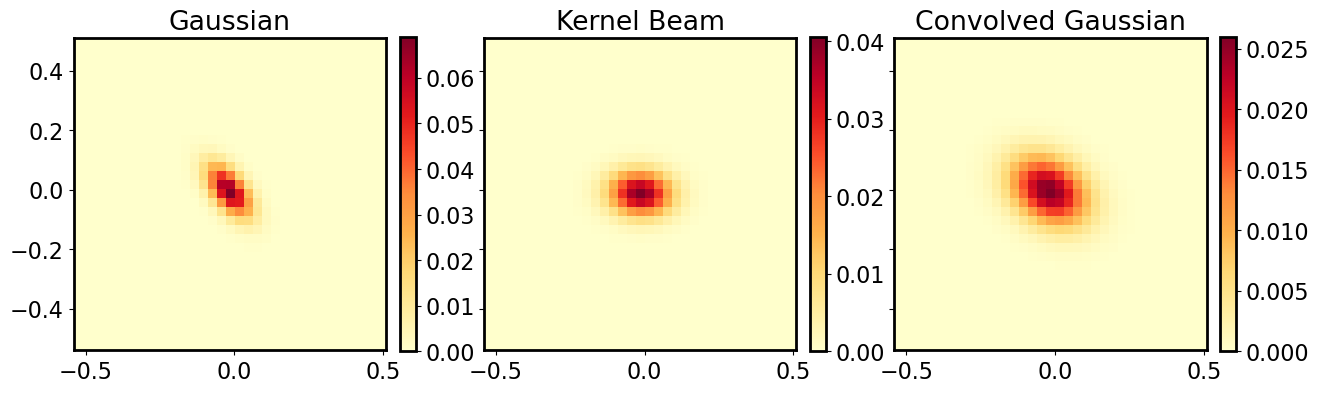

In [25]:
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
amplitude, x_0, y_0, sigma_x, sigma_y, angle, amplitude_sersic, r_eff, ellip, angle_sersic = parameters_fit_50
theta1 = [amplitude, x_0, y_0, sigma_x, sigma_y, angle]
theta2 = [amplitude_sersic, r_eff, x_0, y_0, ellip, angle_sersic]
gauss_point = myUtils.model_twoD_Gaussian(theta1, x_grid, y_grid).reshape(35,35)
beam_gauss_kernel = Gaussian2DKernel(bmaj_s /(dy*3600),bmin_s /(dy*3600),theta=np.radians(bpa-90),x_size=35)
astropy_conv = convolve(gauss_point, beam_gauss_kernel)

model = astropy_conv.ravel() + myUtils.model_Sersic(theta2, x_grid, y_grid)
fid,ax = plt.subplots(nrows = 1 , ncols = 3,sharey=True,figsize=(15,8))

plt1 =ax[0].imshow(gauss_point, cmap='YlOrRd', origin='lower', extent=extent)
plt2 =ax[1].imshow(beam_gauss_kernel, cmap='YlOrRd', origin='lower', extent=extent)
plt3 =ax[2].imshow(convolve(gauss_point, beam_gauss_kernel), cmap='YlOrRd', origin='lower', extent=extent)

fig.colorbar(ax=ax[0], mappable=plt1, orientation='vertical',fraction=0.046, pad=0.04)
ax[0].set_title('Gaussian')
fig.colorbar(ax=ax[1], mappable=plt2, orientation='vertical',fraction=0.046, pad=0.04)
ax[1].set_title('Kernel Beam')

fig.colorbar(ax=ax[2], mappable=plt3, orientation='vertical',fraction=0.046, pad=0.04)
ax[2].set_title('Convolved Gaussian')


plt.show()

In [ ]:
def Tflux(theta, dx, profile, rms, points=2):
    x_grid = np.linspace(-1, 1, 8000)
    y_grid = np.linspace(-1, 1, 8000)
    x_grid, y_grid = np.meshgrid(x_grid, y_grid)
    diff = np.diff(np.linspace(-1, 1, 8000)[0:2])[0]

    if profile == 'B':
        flux = model_twoD_Gaussian(theta, x_grid, y_grid)
        integral = np.sum(flux * diff**2 / (dx*3600)**2) #change the grid dive by dx i change to mJy/pixel and multiplying by diff i select the new size of the pixel
    elif profile == 'A':
        flux = model_Sersic(theta, x_grid, y_grid)
        integral = np.sum(flux * diff ** 2 / (dx * 3600) ** 2)
        
    elif profile == 'C':

        amplitude, x_0, y_0, sigma_x, sigma_y, angle, amplitude_sersic, r_eff, ellip, angle_sersic = theta
        theta1 = [amplitude, x_0, y_0, sigma_x, sigma_y, angle]
        theta2 = [amplitude_sersic, r_eff, x_0, y_0, ellip, angle_sersic]        
        flux = model_twoD_Gaussian(theta1, x_grid, y_grid) + model_Sersic(theta2, x_grid, y_grid)
        integral = np.sum(flux * diff ** 2 / (dx * 3600) ** 2)

    integral_noise = []
    for i in range(0, points):
        noise = np.random.normal(loc=0.0, scale=rms, size=flux.shape)

        flux_noise = flux + noise
        integral_noise.append(np.sum(flux_noise * diff**2 / (dx*3600)**2))

    return integral, np.std(integral_noise)

In [ ]:
amplitude_emcee, x_0_emcee, y_0_emcee, sigma_x_emcee, sigma_y_emcee, angle_emcee

In [ ]:
amplitude, x_0, y_0, sigma_x, sigma_y, angle, amplitude_sersic, r_eff, ellip, angle_sersic = parameters_fit_50
theta1 = [amplitude, x_0, y_0, sigma_x, sigma_y, angle]
integr, integral_noise = myUtils.Tflux( theta1, dx,profile='B',rms=myUtils.std_image(flux))


In [ ]:
theta1

In [ ]:
integr

In [ ]:
theta2 = [amplitude_sersic, r_eff, x_0, y_0, ellip, angle_sersic]        
integr, integral_noise = myUtils.Tflux( theta2, dx,profile='A',rms=myUtils.std_image(flux))
integr

In [ ]:
x_extent = (np.array([0., flux.shape[1]]) - (flux.shape[1] - x_center + 0.5)) * dx * 3600 * (-1)  # half pixel to center the map
y_extent = (np.array([0., flux.shape[0]]) - (flux.shape[0] - y_center + 0.5)) * dy * 3600
extent = [x_extent[0], x_extent[1], y_extent[0], y_extent[1]]

x_grid = np.linspace(x_extent[0], x_extent[1], flux.shape[1])
y_grid = np.linspace(y_extent[0], y_extent[1], flux.shape[0])
x_grid, y_grid = np.meshgrid(x_grid, y_grid)
flux__ = myUtils.model_twoD_Gaussian(theta1, x_grid, y_grid) + myUtils.model_Sersic(theta2, x_grid, y_grid)
fig, ax = plt.subplots()
plt1 = ax.imshow(flux__.reshape(34,34), cmap='YlOrRd', origin='lower', extent=extent, vmin=flux__.min(), vmax=flux__.max())
fig.colorbar(ax=ax, mappable=plt1, orientation='vertical')
ax.set_xlabel('Relative RA [arcsec]')
ax.set_ylabel('Relative Dec [arcsec]')
ax.hlines(0,-.5,0)
ax.vlines(0,-.5,0)
plt.xlim(x_extent[0],x_extent[1])
plt.ylim(y_extent[0],y_extent[1])
plt.show()

In [ ]:
sum(flux__)

In [ ]:
data = data.append({'Source': name,
                        'SN': sn,
                        'Relative RA G+S  [arcsec]': x_0_emcee,
                        'Relative RA G+S low [arcsec]': x_0_emcee_low,
                        'Relative RA G+S up [arcsec]': x_0_emcee_up,
                        'Relative Dec G+S [arcsec]': y_0_emcee,
                        'Relative Dec G+S low': y_0_emcee_low,
                        'Relative Dec G+S up': y_0_emcee_up,
                        'FWHM x G+S [arcsec]': FWHM_x_emcee,
                        'FWHM x G+S low': 2 * np.sqrt(2 * np.log(2)) * sigma_x_emcee_low,
                        'FWHM x G+S up': 2 * np.sqrt(2 * np.log(2)) * sigma_x_emcee_up,
                        'FWHM y G+S [arcsec]': FWHM_y_emcee,
                        'FWHM y G+S low': 2 * np.sqrt(2 * np.log(2)) * sigma_y_emcee_low,
                        'FWHM y G+S up': 2 * np.sqrt(2 * np.log(2)) * sigma_y_emcee_up,
                        'Angle gaussian [deg]': angle_emcee,
                        'Angle gaussian low [deg]': angle_emcee_low,
                        'Angle gaussian up [deg]': angle_emcee_up,
                        'Amplitude G+S [mJy]': amplitude_emcee,
                        'Amplitude G+S low [mJy]': amplitude_emcee_low,
                        'Amplitude G+S up [mJy]': amplitude_emcee_up,
                        'Amplitude sersic G+S [mJy]': amplitude_sersic_emcee,
                        'Amplitude sersic G+S low [mJy]': amplitude_sersic_emcee_low,
                        'Amplitude sersic G+S up [mJy]': amplitude_sersic_emcee_up,
                        'Angle sersic  [deg]': angle_sersic_emcee,
                        'Angle sersic  low [deg]': angle_sersic_emcee_low,
                        'Angle sersic  up [deg]': angle_sersic_emcee_up,
                        'Effective radius S [arcsec]': r_eff_emcee,
                        'Effective radius S low [arcsec]': r_eff_emcee_low,
                        'Effective radius S up [arcsec]': r_eff_emcee_up,
                        'Ellipticity': ellip_emcee,
                        'Ellipticity low': ellip_emcee_low,
                        'Ellipticity up': ellip_emcee_up,                          
                        
                        'BIC G+s': myUtils.bic(parameters_fit_50, x_grid, y_grid, flux, profile)}, ignore_index=True)

In [ ]:
mod = Sersic2D(amplitude = amplitude_sersic, r_eff = r_eff, n=1, x_0=x_0, y_0=y_0,ellip=ellip, theta=np.radians(180-angle_sersic))
sersic = mod(x_grid, y_grid)
Gauss = myUtils.model_twoD_Gaussian([amplitude_emcee, x_0_emcee, y_0_emcee, sigma_x_emcee, sigma_y_emcee, angle_emcee], x_grid, y_grid).reshape(34,34)
plt1 = plt.imshow(sersic, cmap='YlOrRd', origin='lower', extent=extent, vmin=flux.min(), vmax=flux.max())
plt.title('Sersic profile')
plt.show()
plt1 = plt.imshow(Gauss, cmap='YlOrRd', origin='lower', extent=extent, vmin=flux.min(), vmax=flux.max())
plt.title('Gauss profile')
plt.show()
plt1 = plt.imshow(sersic + Gauss, cmap='YlOrRd', origin='lower', extent=extent, vmin=flux.min(), vmax=flux.max())
plt.title('G + S profile')

In [ ]:
data.to_csv('data_fit_Gaussian+Sersic.csv', header=True, index=False)

In [ ]:
pd.read_csv('data_fit_Gaussian+Sersic.csv')

In [ ]:
myUtils.waic_(sampler,labels) #Sersic

In [ ]:
myUtils.waic_(sampler,labels) #gauss

In [ ]:
myUtils.waic_(sampler,labels) #G+S

In [ ]:
# # amplitude_emcee, mu_x_emcee, mu_y_emcee, sigma_x_emcee, sigma_y_emcee, angle_emcee, offset_emcee = parameters_fit_50
# # amplitude_sersic, r_eff, n, x_0, y_0, ellip, angle_sersic = parameters_fit_50
# amplitude_emcee, x_0_emcee, y_0_emcee, sigma_x_emcee, sigma_y_emcee, angle_emcee, amplitude_sersic, r_eff_emcee, ellip, angle_sersic = parameters_fit_50
mod = Sersic2D(amplitude = amplitude_sersic, r_eff = r_eff, n=1, x_0=x_0, y_0=y_0,ellip=ellip, theta=np.radians(angle_sersic))
sersic = mod(x, y)
Gauss = myUtils.model_twoD_Gaussian([amplitude_emcee, x_0_emcee, y_0_emcee, sigma_x_emcee, sigma_y_emcee, angle_emcee], x, y).reshape(34,34)
plt1 = plt.imshow(sersic, cmap='YlOrRd', origin='lower', extent=extent, vmin=flux.min(), vmax=flux.max())
plt.title('Sersic profile')
plt.show()
plt1 = plt.imshow(Gauss, cmap='YlOrRd', origin='lower', extent=extent, vmin=flux.min(), vmax=flux.max())
plt.title('Gauss profile')
plt.show()
plt1 = plt.imshow(sersic + Gauss, cmap='YlOrRd', origin='lower', extent=extent, vmin=flux.min(), vmax=flux.max())
plt.title('G + S profile')

In [ ]:
data = arviz.from_emcee(sampler, 
                        var_names = ['amplitude','mu_x', 'mu_y', 'sigma_x', 'sigma_y', 'angle', 'offset'],
                       )
data.add_groups(
    log_likelihood = {"log likelihood": like_samps['log_likelihood_'].T})

In [ ]:
data = data.sel(draw=slice(1000, None))


In [ ]:
l = data.log_likelihood['log likelihood'].stack(__sample__=("chain", "draw"))
(l.var(dim="__sample__")>0.4).sum()

In [ ]:
arviz.waic(data)

In [ ]:
arviz.loo(data)

In [ ]:
n_data_points

In [ ]:
compare_dict = {"non centered": data, "centered": data}
arviz.compare(compare_dict)

In [ ]:
myUtils.bic( pos[0], x, y, flux, 7)

In [ ]:
# like_samps = sampler.get_blobs()
# like_samps_flat = np.zeros((2000,300,34*34))

# for i in range(like_samps.shape[0]):
#     for j in range(like_samps.shape[1]):
#         like_samps_flat[i][j][:] =like_samps[i][j][0]

# del(like_samps)
# like_samps_flat = like_samps_flat.reshape(2000*300, 1156)        

# # lpdi = np.log(np.mean(like_samps_flat,axis=0))
# vari = np.var(np.log(like_samps_flat),axis=0)
# # # del(like_samps_flat)
# # lpdimean = sum(lpdi)
# # pwaic = sum(vari) 
# # WAIC = -2*lpdimean + 2*pwaic 
# # WAIC

In [ ]:

mod = Sersic2D(amplitude = 1, r_eff = 10, n=1, x_0=17, 
               y_0=17,ellip=.7, theta=np.radians(0))
fobs2 = mod(x, y).reshape(34,34)
plt.hlines(16.5,16.5,26.5,'red')
plt.imshow(fobs2)
plt.show()

In [ ]:
theta = [2, 0, 0, 4, 4, 0]
x_grid = np.linspace(-10, 10, 34)
y_grid = np.linspace(-10, 10, 34)
x_grid, y_grid = np.meshgrid(x_grid, y_grid)
flux = myUtils.model_twoD_Gaussian(theta,x_grid,y_grid).reshape(34,34)

In [ ]:
ax = plt.axes(projection='3d')
ax.plot_surface(x_grid, y_grid, flux,rstride=1, cstride=1,
                cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.axis('off')


In [ ]:
4*1.677